# 下準備

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow 
from keras.models import Sequential
from keras.layers import Dense

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset,DataLoader
import torch.optim as optim
import scipy.stats
# 高解像度ディスプレイ用
# from IPython.display import set_matplotlib_formats
from matplotlib_inline.backend_inline import set_matplotlib_formats # バージョンによってはこちらを有効に
set_matplotlib_formats('retina')

## GKのOVRをGK用の能力値で説明したい

### keras

In [6]:
df = pd.read_csv("/python/csv/1200.csv")

dfGK = df[df['Position'] == 'GK']
print(len(dfGK))
X = dfGK.iloc[:,30:35].values.astype(np.float32)
Y = dfGK['Overall Rating'].values.astype(np.float32)

threshold = np.round(129*.8).astype(np.int64)
X_train = X[0:threshold]
X_test = X[threshold:]
Y_train = Y[0:threshold]
Y_test = Y[threshold:]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

def custom_loss(y_val, y_pred):
    # tensorflow.cast(y_pred|y_val, tensorflow.float32|tensorflow.int64)
    error = y_val - y_pred
    loss = tf.math.reduce_mean(error**2) / 1000
    return loss

129
(103, 5)
(26, 5)
(103,)
(26,)


In [7]:
# 入力層
# ニューロン数 = 3
# 中間層1
# ニューロン数 = 64
# 中間層2
# ニューロン数 = 32
# 出力層
# ニューロン数 = 1
nn1 = 64
nn2 = 32
model = Sequential()
model.add(Dense(nn1, activation='relu', input_dim=5))
model.add(Dense(nn2, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
          loss='mean_squared_error',
          # loss = custom_loss,
          metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [92]:
train_history = model.fit(X_train, Y_train,
        validation_data = (X_test, Y_test),
        batch_size=10,
        epochs=1000,
        verbose=0)

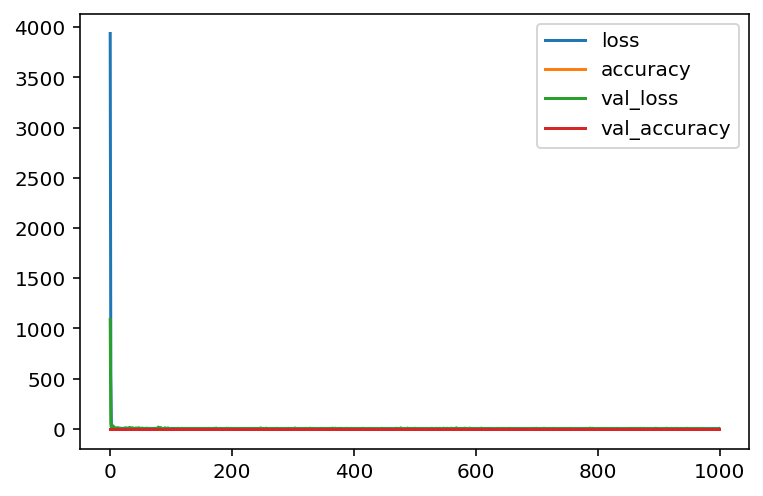

In [93]:
results = pd.DataFrame(train_history.history)
results.plot();

In [94]:
results.head()

,loss,accuracy,val_loss,val_accuracy
0,3937.407227,0.0,1089.822021,0.0
1,547.286011,0.0,56.907547,0.0
2,20.572062,0.0,1.847921,0.0
3,1.952926,0.0,2.437311,0.0
4,1.932476,0.0,4.242843,0.0


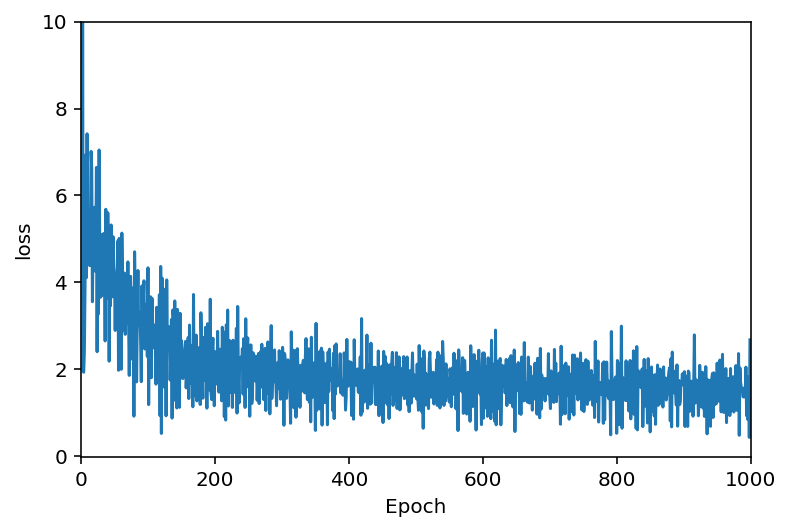

In [95]:
len(train_history.history['loss']) #=> 3000
train_history.history.keys() #=>dict_keys(['loss', 'accuracy'])
# print(train_history.history)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(train_history.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
ax.set_xlim(0, len(train_history.history['loss']))
ax.set_ylim(-0.01, 10.0)
# plt.savefig('nn-regression-train-1.png', dpi=300, facecolor='white')
plt.show()

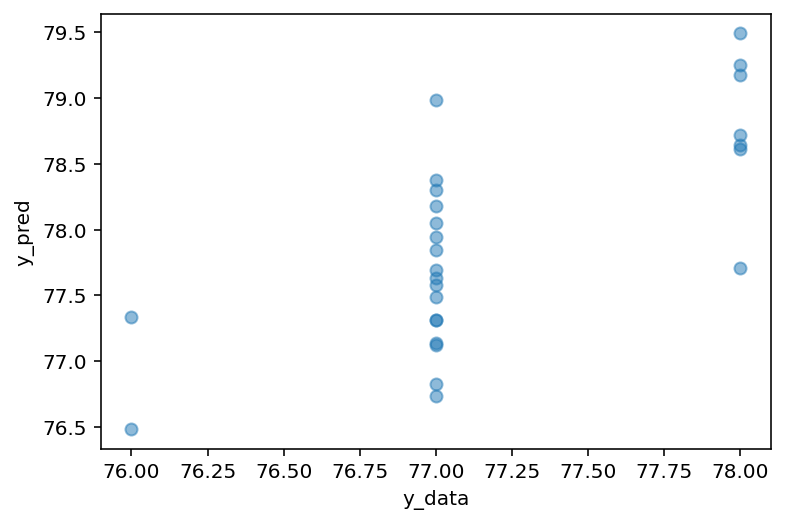

In [96]:
Y_pred = model.predict(X_test)
# print(Y_pred)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(Y_test, Y_pred, alpha=0.5)
ax.set_xlabel('y_data')
ax.set_ylabel('y_pred')
# ax.set_xlim(-1.1,1.3)
# ax.set_ylim(-1.1,1.3)
# plt.savefig('nn-regression-predict.png', dpi=300, facecolor='white')
plt.show()

## GK以外

### 確率的勾配降下法で

In [25]:
df = pd.read_csv("/python/csv/1200.csv")
dfNotGK = df[df['Position'] != 'GK']
# シャッフル
dfNotGK_s  = dfNotGK.sample(frac=1, random_state=0)
# len(dfNotGK_s) #=>1071
X = dfNotGK_s.iloc[:,1:30].values
Y = dfNotGK_s['Overall Rating'].values
from sklearn.preprocessing import StandardScaler
# # 標準化
sc = StandardScaler()
sc.fit(X)
StandardScaler(copy=True, with_mean=True, with_std=True)
X = sc.transform(X)
sc.fit(Y.reshape(-1, 1))
Y = sc.transform(Y.reshape(-1, 1)) 

# 80%を訓練、残りをテストに分ける。その際整数にしないとエラー
threshold = np.round(len(dfNotGK_s)*.8).astype(np.int64)
X_train = X[0:threshold]
X_test = X[threshold:]
Y_train = Y[0:threshold]
Y_test = Y[threshold:]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(857, 29)
(214, 29)
(857, 1)
(214, 1)


In [26]:
# PyTorchのオブジェクトに変換しておく。訓練データは len(dfNotGK_s) × 29 の行列X、 len(dfNotGK_s) ×1 の行列Y
# 個人的にはnparrayを最初に作っておいて最後にtorchにした方がよさげ。numpyのほうが形整形とかしやすかった
# expVal
# tensor([[ 0.3740,  0.8512,  0.0332,  ..., -3.4436, -3.3754, -3.1709],
#         [ 0.5104, -1.3303, -0.7849,  ...,  0.3058,  0.6467,  0.4422],
#         [ 0.5104,  0.1013, -1.1257,  ..., -1.6711, -1.7393, -2.0120],
#         ...,
#         [ 0.2377, -1.1257, -0.3077,  ...,  0.2377,  0.5104,  0.3740],
#         [-1.0576, -1.0576, -0.8531,  ...,  0.5104,  0.5104,  0.2377],
#         [ 1.1239, -0.3077, -0.6485,  ...,  0.1013,  0.2377,  0.1695]])
# objVal
# tensor([[-0.8742],
#         [ 0.4783],
#         [-0.5361],
#         ...,
#         [-0.8742],
#         [-0.1979],
#         [-0.5361]])

dtype = torch.float
expVal = torch.from_numpy(X_train).type(dtype)
objVal = torch.from_numpy(Y_train.reshape(-1, 1)).type(dtype)
expValTest = torch.from_numpy(X_test).type(dtype)
objValTest = torch.from_numpy(Y_test.reshape(-1, 1)).type(dtype)
# print(expVal.size()) #=> torch.Size([857, 29])
# print(objVal.size()) #=> torch.Size([857, 1])

**29のパラメタからの重回帰を確率的勾配降下法で実施**

In [27]:
batch = 10
epoch = 100
eta = 0.0001

# Create a data loader with batch size of batch.
dataset = TensorDataset(expVal, objVal)
loader = DataLoader(dataset, batch_size=batch, shuffle=True)
# Parameters of the single-layer neural network.
w = torch.randn(29, 1, dtype=dtype, requires_grad=True)
b = torch.randn(1, dtype=dtype, requires_grad=True)

H = []
for t in range(epoch):
    sumloss = 0.
    for x, y in loader:
        y_hat = x.matmul(w) + b
        l = (y - y_hat) * (y - y_hat)
        loss = l.sum()
        # print(loss)
        sumloss += loss.item()

        loss.backward()
        with torch.no_grad():
            w -= eta * w.grad
            b -= eta * b.grad
            w.grad.zero_()
            b.grad.zero_()    
    H.append(sumloss)

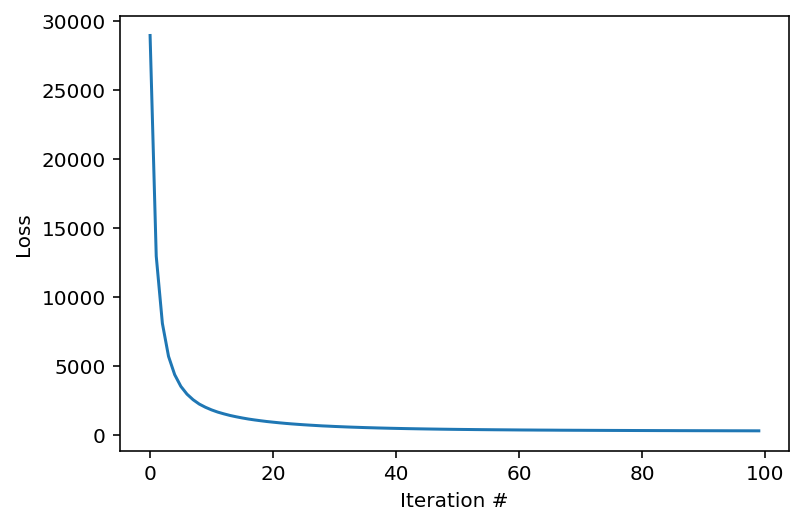

In [28]:
fig, ax = plt.subplots()
ax.plot(H)
ax.set_xlabel('Iteration #')
ax.set_ylabel('Loss')
plt.show()

### kerasじゃないやつで

In [29]:
df = pd.read_csv("/python/csv/1200.csv")
dfNotGK = df[df['Position'] != 'GK']
# シャッフル
dfNotGK_s  = dfNotGK.sample(frac=1, random_state=1)
dfNotGK = dfNotGK_s
# len(dfNotGK_s) #=>1071

# 一般化。今回のパラメタ数とdfに代入
param = 29
thisDf = dfNotGK

X =thisDf.iloc[:,1:(param+1)].values
Y = thisDf['Overall Rating'].values

# # 標準化
# X = scipy.stats.zscore(X, axis=None)
# Y = scipy.stats.zscore(Y, axis=None)

# # 標準化
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc.fit(X)
# StandardScaler(copy=True, with_mean=True, with_std=True)
# X = sc.transform(X)
# sc.fit(Y.reshape(-1, 1))
# Y = sc.transform(Y.reshape(-1, 1))
# これで戻せる 
# sc.inverse_transform(Y)

# 100でわった
Xdiv100 = np.array([x/100.0 for x in np.squeeze(X.reshape(1,param*len(thisDf)))]) #=>array([0.85, 0.95, 0.7 , ..., 0.23, 0.31, 0.26])
Xdiv100 = Xdiv100.reshape(len(thisDf),-1)
Ydiv100 = np.array([y/100.0 for y in Y]) #=>array([0.85, 0.95, 0.7 , ..., 0.23, 0.31, 0.26])
# Ydiv100.reshape(len(dfNotGK),-1)

# モデル一つ目はこれのみ
X = Xdiv100
Y = Ydiv100

# モデル二つ目はこれも
X = X.reshape(len(thisDf),1,param)
Y = Y.reshape(len(thisDf),1,1)

# 80%を訓練、残りをテストに分ける。その際整数にしないとエラー
threshold = np.round(len(thisDf)*.8).astype(np.int64)
X_train = X[0:threshold]
X_test = X[threshold:]
Y_train = Y[0:threshold]
Y_test = Y[threshold:]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(857, 1, 29)
(214, 1, 29)
(857, 1, 1)
(214, 1, 1)


**Kerasを使う場合は(857, 1, 29)ではなくて(857, 29, 1)にするはず**

In [30]:
# numpyをtensorにかえる
dtype = torch.float
expVal = torch.from_numpy(X_train).type(dtype)
objVal = torch.from_numpy(Y_train.reshape(-1, 1)).type(dtype)
expValTest = torch.from_numpy(X_test).type(dtype)
objValTest = torch.from_numpy(Y_test.reshape(-1, 1)).type(dtype)
# print(expVal.size()) #=> torch.Size([857, 29])
# print(objVal.size()) #=> torch.Size([857, 1])

# Create a data loader with batch size of batch.
batch = 10
train_dataset = TensorDataset(expVal, objVal)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
# Create a data loader with batch size of batch.
test_dataset = TensorDataset(expValTest, objValTest)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [31]:
# ニューラルネットワークのモデル

# class MyCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # in_features：入力値の数、out_features：出力値の数
#         # 線形回帰と言うことで、nnから「Linear」モデルを使います
#         self.linear = nn.Linear(in_features=param, out_features=1)
#     # 順伝播、forwardを定義しておくと、学習中に自動的に呼ばれる
#     # forward関数を定義して、順伝播の処理内容を書きます
#     # self.linear(x)が計算した結果をoutputとして返却しています
#     # 義したforward関数は学習中にスーパークラスから自動的に呼び出されます
#     def forward(self, x):
#         output = self.linear(x)
#         return output

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.features = nn.Sequential(
          nn.Conv1d(1, 16,kernel_size=3, padding=2, stride=3),
          nn.BatchNorm1d(16),
          nn.ReLU(),
          nn.Conv1d(16, 32,kernel_size=2, padding=2, stride=1),
          nn.BatchNorm1d(32),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=3, stride=1),
          nn.Conv1d(32,64,kernel_size=3, stride=1),
          nn.AdaptiveAvgPool1d(1))
        self.classifier = nn.Sequential(
           nn.Linear(64,32),
           nn.Linear(32,1))

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyCNN().to(device)
# loss 関数の定義
criterion = nn.MSELoss()
# 最適化関数として確率的勾配降下法(SGD)
# 第1引数：model.parameters() => 重みとバイアスの情報が入っている。これを更新したい。
# 第2引数：学習率
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

**これは学習前にやったらあかん**

In [32]:
# from torchsummary import summary
# model = MyCNN()  
# #conv1dなら入力は => summary(model,(inputchannels,データ数))
# # データ数ってのはconv1dに与えるinputの3次元目のやつ、今回なら29
# summary(model,(1,29)) 
# #conv2dなら入力は => summary(model,(inputchannels,H,W))

In [33]:
from numpy.core.numeric import correlate
# 訓練用の関数
def train(train_loader):
    model.train()
    loss = 0
    correct = 0
    total = 0
    for x, y in train_loader:
        # 勾配の初期化を行う
        optimizer.zero_grad()
        # 予測値の計算
        output = model(x)
        # 損失の計算：予想値と正解値を与える
        _loss = criterion(output, y)
        # バッチサイズの大きさでとってきたやつらのロスの合計。結局forで全部、つまり857個に対してやるから、lossの合計は最終的には変わらない。
        loss += _loss.item()
        # 差を求める
        dif = [abs(output-y)[i].item() for i in range(y.size(0))]
        for adif in dif:
          if(adif < 0.01):
            correct += 1
        # バッチサイズの大きさでいくつやったか考えている。今回だと10,20,30…850,857となる。もしtotal += 1だと1,2,…86になってtotalをうまく数えられない
        total += y.size(0)
        # 損失を誤差逆伝播する
        _loss.backward()
        # 重みとバイアスの更新
        optimizer.step()
    train_loss = loss / len(train_loader) 
    train_acc = correct / total
    return train_loss, train_acc


# 評価用の関数:パラメータ更新がない
def valid(test_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            _loss = criterion(output, y)
            loss += _loss.item()
            dif = [abs(output-y)[i].item() for i in range(y.size(0))]
            for adif in dif:
              if(adif < 0.02):
                correct += 1
            total += y.size(0)
    val_loss = loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [34]:
# epoch毎の記録用空配列
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epo = 800

# 実行
for epoch in range(epo):
    train_loss, train_acc = train(train_loader)
    val_loss, val_acc = valid(test_loader)
    # print('epoch %d, train_loss: %.4f train_acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, train_loss, train_acc, val_loss, val_acc))
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

finalOutputs = []
reals = []
with torch.no_grad():
    for x, y in test_loader:
        finalOutput = model(x)
        for i in range(y.size(0)):
          finalOutputs.append(finalOutput[i].item())
          reals.append(y[i].item())

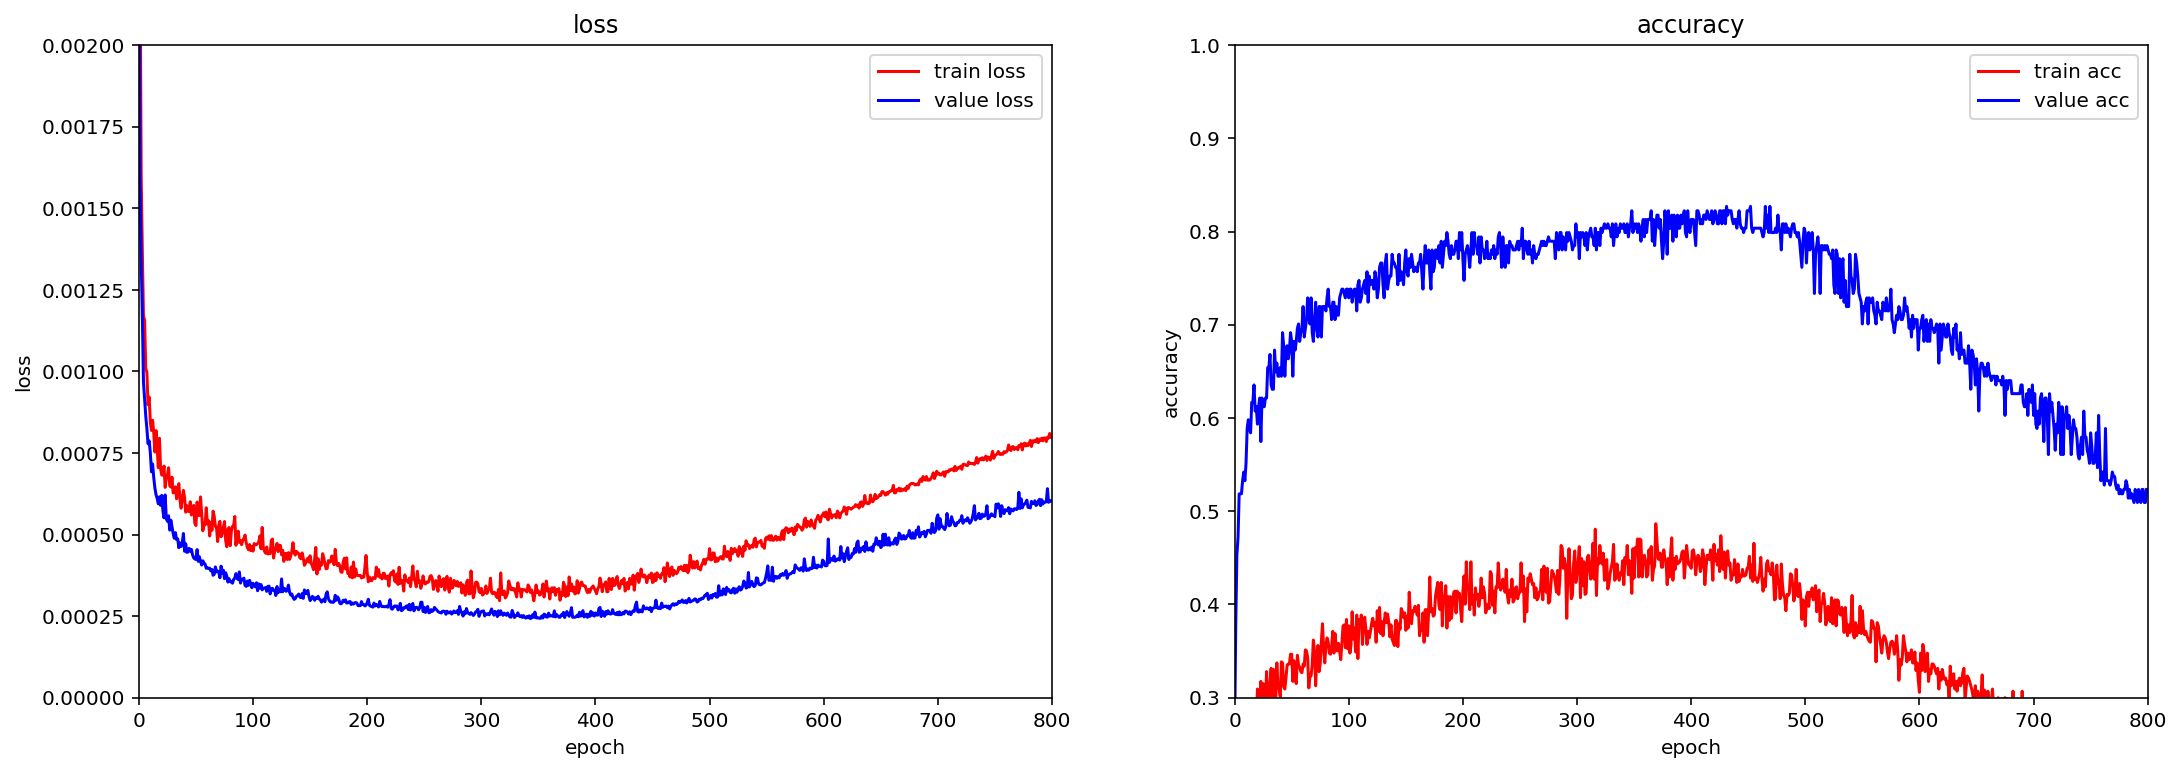

In [35]:
plt.figure(figsize=(18,6))    
plt.subplot(1,2,1)
plt.plot(range(epo), train_loss_list,  color='red')
plt.plot(range(epo), val_loss_list, color='blue')
plt.xlim(0, epo)
plt.ylim(0, 0.002)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'value loss'])
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(range(epo), train_acc_list,  color='red')
plt.plot(range(epo), val_acc_list,  color='blue')
plt.xlim(0, epo)
plt.ylim(0.3, 1.0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train acc', 'value acc'])
plt.title('accuracy')

plt.show()

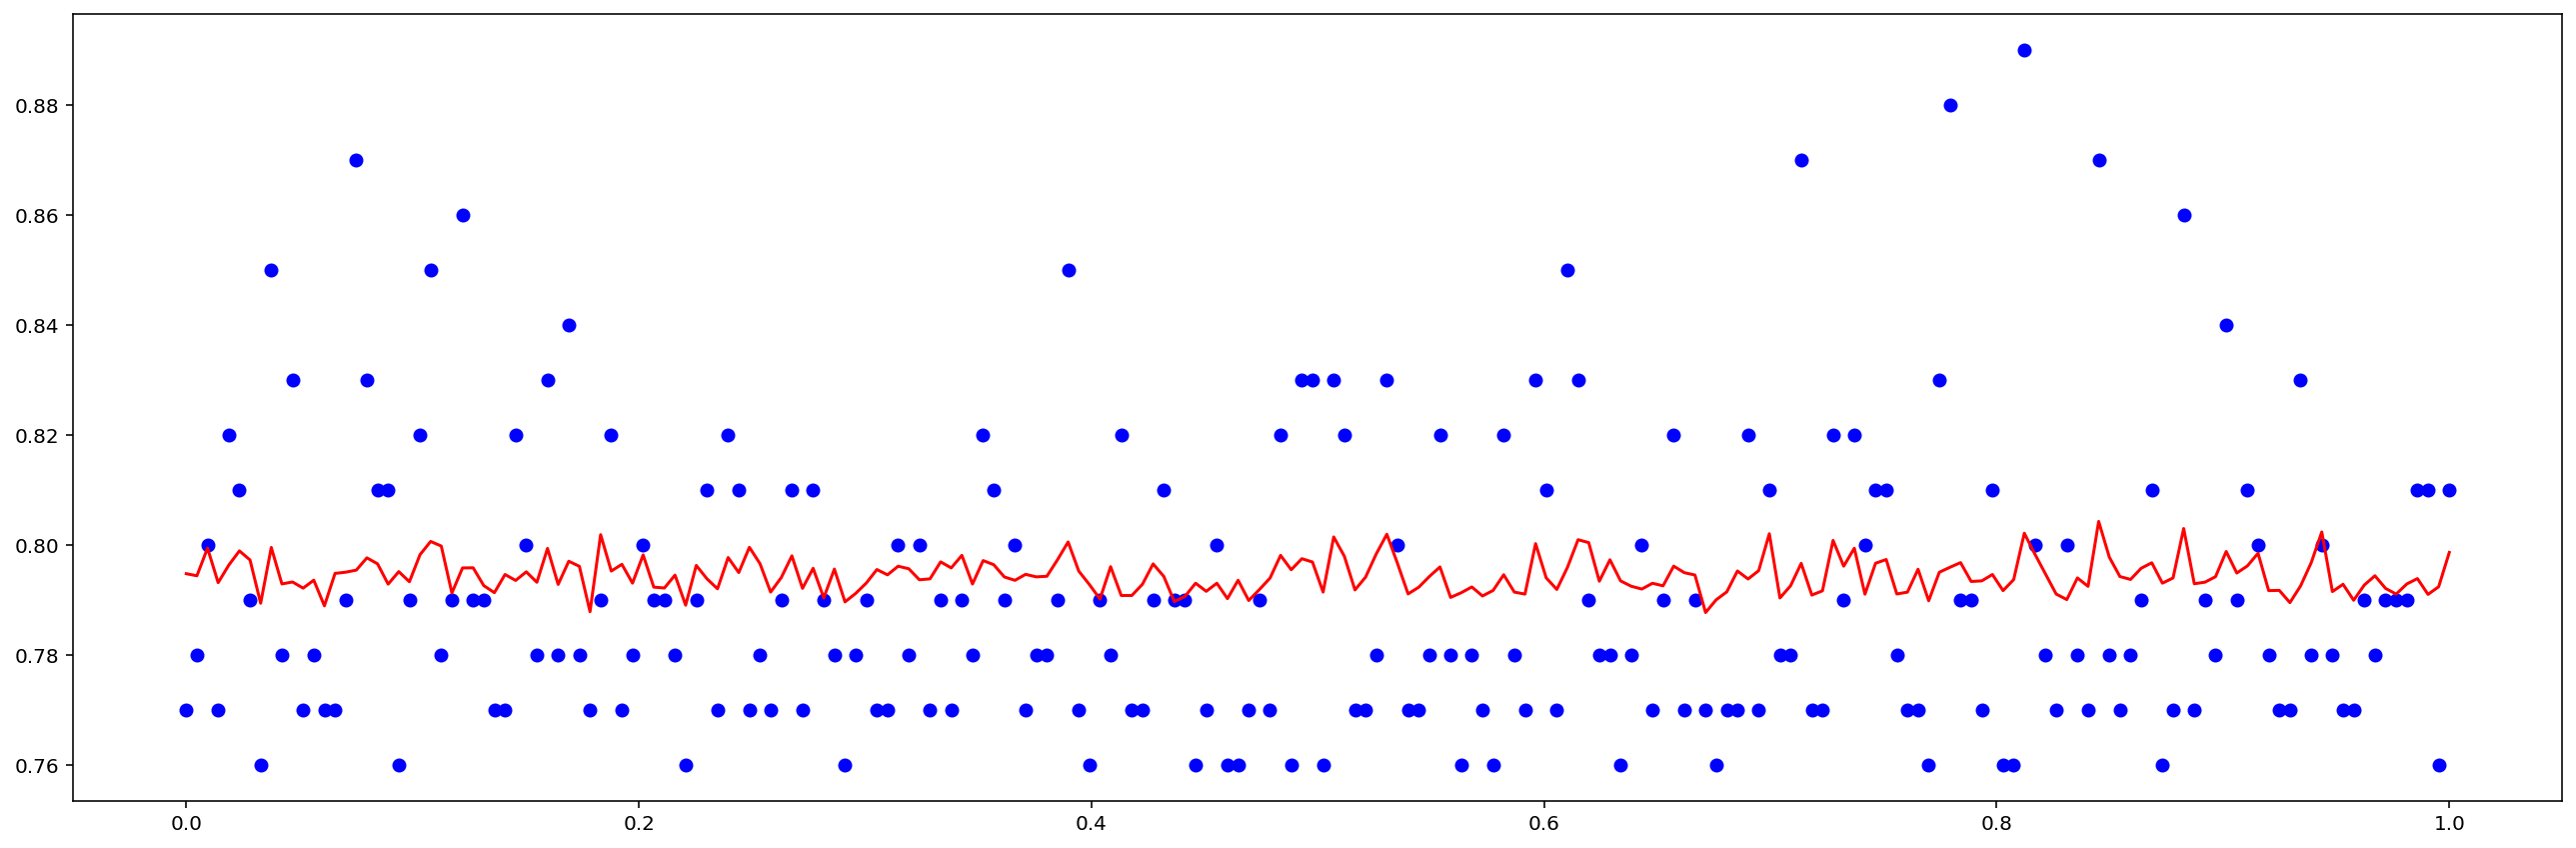

In [36]:
x = np.linspace(0,1,len(reals))
plt.figure(figsize=(18,6))  
plt.scatter(x,reals,c='b' )
plt.plot(x, finalOutputs, c='r')
plt.tight_layout();plt.show()